In [40]:
from Net import Net
import torch
import torch.nn as nn
from AuxiliaryFunctions import save_checkpoint, save_recon, fig_to_img,get_plottable_frame
from VideoDataset import VideoDataset
from VideoTransforms import *
from torch.utils.data import DataLoader
from torchvision import transforms
from timeit import default_timer as timer
from datetime import datetime
import matplotlib.pyplot as plt
import os
from pathlib import Path, PureWindowsPath

In [41]:
def train(model,loader,device, num_epochs,directory, batch_size=4, learning_rate=1e-3,model_name='model',checkpoint=[]):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    start_idx = 0
    running_losses=[]
    if isinstance(checkpoint,dict):
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        optimizer.lr=learning_rate
        start_idx = checkpoint['epoch']
    for epoch in range(start_idx,num_epochs):
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
            optimizer.zero_grad()
            clips = data['clip'].to(device)
            reconstruction = model(clips)
            loss = criterion(clips,reconstruction)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*clips.size(0)
            if i % 1000 == 0:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
        
        save_checkpoint(model,optimizer,epoch,running_loss,directory=directory,name=model_name)
        print(running_loss)
        running_losses.append(running_loss)
        save_recon(reconstruction,model_name,epoch,directory)
    return running_losses


In [3]:
directory='G:\My Drive\PhD\cut_swim_samples'#'/Volumes/GoogleDrive/My Drive/PhD/cut_swim_samples'
ds=VideoDataset(directory,num_frames=20, 
                transform=transforms.Compose([Rescale(256),ToTensor()]),swim_sample=False)
dataloader = DataLoader(ds, batch_size=4,
                        shuffle=True, num_workers=4)
len(ds)

5445

In [4]:
batch = next(iter(dataloader))
batch['clip'].shape

In [26]:

path = 'G:\My Drive\PhD\cut_swim_samples\model_outputs\model_091120_20frms_epoch316.pt'
checkpoint=torch.load(path)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(color_channels=1)
model.to(device)
start = timer()
run_loss=train(model,dataloader,device,num_epochs=500, directory='G:\My Drive\PhD\cut_swim_samples\model_outputs' ,
               model_name='model_091120_20frms',checkpoint=checkpoint)
end = timer()
print(f'elapsed training time {end-start} sec')

[317,     1] loss: 0.013
[317,  1001] loss: 0.007
32.66747664473951
[318,     1] loss: 0.007
[318,  1001] loss: 0.008
32.76726234238595
[319,     1] loss: 0.005
[319,  1001] loss: 0.007
32.813081754837185
[320,     1] loss: 0.007
[320,  1001] loss: 0.007
32.95406344998628
[321,     1] loss: 0.006
[321,  1001] loss: 0.007
33.02774846740067
[322,     1] loss: 0.005
[322,  1001] loss: 0.007
32.853630220051855
[323,     1] loss: 0.005
[323,  1001] loss: 0.009
33.026545672211796
[324,     1] loss: 0.005
[324,  1001] loss: 0.005
32.83890663320199
[325,     1] loss: 0.005
[325,  1001] loss: 0.006
32.80183506314643
[326,     1] loss: 0.004
[326,  1001] loss: 0.006
32.88850161340088
[327,     1] loss: 0.005
[327,  1001] loss: 0.008
32.79689347697422
[328,     1] loss: 0.003
[328,  1001] loss: 0.006
32.79738889122382
[329,     1] loss: 0.005
[329,  1001] loss: 0.006
32.79790577944368
[330,     1] loss: 0.007
[330,  1001] loss: 0.006
32.77079851971939
[331,     1] loss: 0.007
[331,  1001] loss: 0

[437,  1001] loss: 0.005
33.24010368064046
[438,     1] loss: 0.007
[438,  1001] loss: 0.006
33.342025589197874
[439,     1] loss: 0.005
[439,  1001] loss: 0.006
33.45348698878661
[440,     1] loss: 0.009
[440,  1001] loss: 0.005
33.49437249219045
[441,     1] loss: 0.006
[441,  1001] loss: 0.004
33.380631738342345
[442,     1] loss: 0.005
[442,  1001] loss: 0.007
33.31991517636925
[443,     1] loss: 0.005
[443,  1001] loss: 0.006
33.36164956679568
[444,     1] loss: 0.005
[444,  1001] loss: 0.005
33.62923255749047
[445,     1] loss: 0.005
[445,  1001] loss: 0.005
33.69543340243399
[446,     1] loss: 0.006
[446,  1001] loss: 0.006
33.63098529540002
[447,     1] loss: 0.006
[447,  1001] loss: 0.008
33.536597115918994
[448,     1] loss: 0.007
[448,  1001] loss: 0.006
33.406228804495186
[449,     1] loss: 0.005
[449,  1001] loss: 0.005
33.52523221122101
[450,     1] loss: 0.009
[450,  1001] loss: 0.006
33.601014744257554
[451,     1] loss: 0.005
[451,  1001] loss: 0.007
33.66403586510569


In [14]:
device

device(type='cuda')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

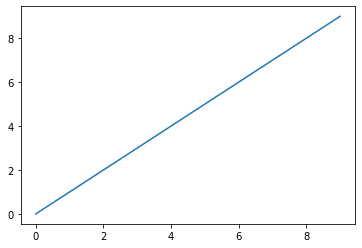

In [3]:
fig=plt.figure()
plt.plot(range(10),range(10))
fig_to_img(fig)

In [88]:
directory=str(Path('G:/My Drive/PhD/regularvid'))#'/Volumes/GoogleDrive/My Drive/PhD/regular_vid'#
#'/Volumes/GoogleDrive/My Drive/PhD/cut_swim_samples'
ds=VideoDataset(directory,num_frames=20, 
                transform=transforms.Compose([Rescale(256),ToTensor()]),swim_sample=False)
dataloader = DataLoader(ds, batch_size=1,
                        shuffle=False, num_workers=1)

In [50]:
path=str(Path('G:/My Drive/PhD/regularvid/model_overfit_291120_20frms_epoch699.pt'))
checkpoint=torch.load(path)


In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(color_channels=1)
model.to(device)
start = timer()
run_loss=train(model,dataloader,device,num_epochs=3000, directory=directory,batch_size=1,
               learning_rate=1e-4,
               model_name='model_overfit_291120_20frms',
              checkpoint=checkpoint)
end = timer()
print(f'elapsed training time {end-start} sec')

[700,     1] loss: 0.006
0.006379611790180206
[701,     1] loss: 0.006
0.006486921105533838
[702,     1] loss: 0.006
0.006411535199731588
[703,     1] loss: 0.006
0.006159601733088493
[704,     1] loss: 0.006
0.006207283120602369
[705,     1] loss: 0.006
0.006405069958418608
[706,     1] loss: 0.006
0.0063112638890743256
[707,     1] loss: 0.006
0.006173103116452694
[708,     1] loss: 0.006
0.0061272503808140755
[709,     1] loss: 0.006
0.006216132547706366
[710,     1] loss: 0.006
0.0062923794612288475
[711,     1] loss: 0.006
0.006154515780508518
[712,     1] loss: 0.006
0.006092572584748268
[713,     1] loss: 0.006
0.0061688232235610485
[714,     1] loss: 0.006
0.006208394654095173
[715,     1] loss: 0.006
0.006203982979059219
[716,     1] loss: 0.006
0.006093665957450867
[717,     1] loss: 0.006
0.006082354113459587
[718,     1] loss: 0.006
0.006150477100163698
[719,     1] loss: 0.006
0.006160843651741743
[720,     1] loss: 0.006
0.006123832892626524
[721,     1] loss: 0.006
0.006

[878,     1] loss: 0.006
0.005529981572180986
[879,     1] loss: 0.006
0.005529425572603941
[880,     1] loss: 0.006
0.005522897467017174
[881,     1] loss: 0.006
0.0055196527391672134
[882,     1] loss: 0.006
0.005522467195987701
[883,     1] loss: 0.006
0.005519673693925142
[884,     1] loss: 0.006
0.005516474600881338
[885,     1] loss: 0.006
0.005514584016054869
[886,     1] loss: 0.006
0.005518678110092878
[887,     1] loss: 0.006
0.005520735401660204
[888,     1] loss: 0.006
0.005517784506082535
[889,     1] loss: 0.006
0.0055149453692138195
[890,     1] loss: 0.006
0.0055109732784330845
[891,     1] loss: 0.006
0.005506201647222042
[892,     1] loss: 0.005
0.005499649327248335
[893,     1] loss: 0.005
0.005496176891028881
[894,     1] loss: 0.005
0.005488716531544924
[895,     1] loss: 0.005
0.005491149146109819
[896,     1] loss: 0.005
0.00548331905156374
[897,     1] loss: 0.005
0.00548196816816926
[898,     1] loss: 0.005
0.0054802619852125645
[899,     1] loss: 0.005
0.00547

0.005403363145887852
[1055,     1] loss: 0.005
0.005247132852673531
[1056,     1] loss: 0.005
0.005254924297332764
[1057,     1] loss: 0.005
0.0053467052057385445
[1058,     1] loss: 0.005
0.005422169342637062
[1059,     1] loss: 0.005
0.005402191076427698
[1060,     1] loss: 0.005
0.005237205419689417
[1061,     1] loss: 0.005
0.005158047191798687
[1062,     1] loss: 0.005
0.005191278178244829
[1063,     1] loss: 0.005
0.005255674012005329
[1064,     1] loss: 0.005
0.005296867340803146
[1065,     1] loss: 0.005
0.005195103585720062
[1066,     1] loss: 0.005
0.005130580626428127
[1067,     1] loss: 0.005
0.005152401514351368
[1068,     1] loss: 0.005
0.005208838265389204
[1069,     1] loss: 0.005
0.005184612702578306
[1070,     1] loss: 0.005
0.005147484131157398
[1071,     1] loss: 0.005
0.005110547412186861
[1072,     1] loss: 0.005
0.0051421779207885265
[1073,     1] loss: 0.005
0.005180143751204014
[1074,     1] loss: 0.005
0.005152068566530943
[1075,     1] loss: 0.005
0.005121455

0.004869400057941675
[1229,     1] loss: 0.005
0.004881735425442457
[1230,     1] loss: 0.005
0.004896550439298153
[1231,     1] loss: 0.005
0.004888995550572872
[1232,     1] loss: 0.005
0.004890941549092531
[1233,     1] loss: 0.005
0.00486731668934226
[1234,     1] loss: 0.005
0.004850440658628941
[1235,     1] loss: 0.005
0.0048264930956065655
[1236,     1] loss: 0.005
0.004826453048735857
[1237,     1] loss: 0.005
0.004830308724194765
[1238,     1] loss: 0.005
0.004818052984774113
[1239,     1] loss: 0.005
0.004837377928197384
[1240,     1] loss: 0.005
0.00483735091984272
[1241,     1] loss: 0.005
0.0048489621840417385
[1242,     1] loss: 0.005
0.004856396466493607
[1243,     1] loss: 0.005
0.004864137154072523
[1244,     1] loss: 0.005
0.004876111634075642
[1245,     1] loss: 0.005
0.004885652102530003
[1246,     1] loss: 0.005
0.004881377797573805
[1247,     1] loss: 0.005
0.0049254014156758785
[1248,     1] loss: 0.005
0.004955865442752838
[1249,     1] loss: 0.005
0.0050287069

0.004986046347767115
[1403,     1] loss: 0.005
0.005288443993777037
[1404,     1] loss: 0.005
0.0051798392087221146
[1405,     1] loss: 0.005
0.005451166536659002
[1406,     1] loss: 0.005
0.005131427198648453
[1407,     1] loss: 0.005
0.0051210978999733925
[1408,     1] loss: 0.005
0.004789281636476517
[1409,     1] loss: 0.005
0.004683331586420536
[1410,     1] loss: 0.005
0.004702999256551266
[1411,     1] loss: 0.005
0.004809217527508736
[1412,     1] loss: 0.005
0.00494238780811429
[1413,     1] loss: 0.005
0.004857469350099564
[1414,     1] loss: 0.005
0.004886256530880928
[1415,     1] loss: 0.005
0.004653105512261391
[1416,     1] loss: 0.005
0.004616355057805777
[1417,     1] loss: 0.005
0.004690205212682486
[1418,     1] loss: 0.005
0.0047316839918494225
[1419,     1] loss: 0.005
0.004760073032230139
[1420,     1] loss: 0.005
0.004671004135161638
[1421,     1] loss: 0.005
0.004633170552551746
[1422,     1] loss: 0.005
0.0046153306029737
[1423,     1] loss: 0.005
0.00462218234

0.004889481235295534
[1577,     1] loss: 0.005
0.005316218826919794
[1578,     1] loss: 0.005
0.005170165095478296
[1579,     1] loss: 0.005
0.00547776510939002
[1580,     1] loss: 0.005
0.00480952113866806
[1581,     1] loss: 0.005
0.004559433087706566
[1582,     1] loss: 0.004
0.004441350698471069
[1583,     1] loss: 0.005
0.004569749813526869
[1584,     1] loss: 0.005
0.004813173785805702
[1585,     1] loss: 0.005
0.004899144172668457
[1586,     1] loss: 0.005
0.00508788600564003
[1587,     1] loss: 0.005
0.004703344777226448
[1588,     1] loss: 0.005
0.004542089067399502
[1589,     1] loss: 0.004
0.004491633269935846
[1590,     1] loss: 0.005
0.00461658276617527
[1591,     1] loss: 0.005
0.0048010144382715225
[1592,     1] loss: 0.005
0.0047540622763335705
[1593,     1] loss: 0.005
0.004826516378670931
[1594,     1] loss: 0.004
0.004494799766689539
[1595,     1] loss: 0.004
0.004454744514077902
[1596,     1] loss: 0.005
0.004540769383311272
[1597,     1] loss: 0.005
0.0046094921417

[1751,     1] loss: 0.004
0.0041831666603684425
[1752,     1] loss: 0.004
0.004184357356280088
[1753,     1] loss: 0.004
0.004185070749372244
[1754,     1] loss: 0.004
0.004174592439085245
[1755,     1] loss: 0.004
0.004185684025287628
[1756,     1] loss: 0.004
0.004190504550933838
[1757,     1] loss: 0.004
0.004167580511420965
[1758,     1] loss: 0.004
0.00416945293545723
[1759,     1] loss: 0.004
0.004187326412647963
[1760,     1] loss: 0.004
0.00418334873393178
[1761,     1] loss: 0.004
0.004170443397015333
[1762,     1] loss: 0.004
0.004164079669862986
[1763,     1] loss: 0.004
0.0041709234938025475
[1764,     1] loss: 0.004
0.004172759596258402
[1765,     1] loss: 0.004
0.004168773535639048
[1766,     1] loss: 0.004
0.004165144171565771
[1767,     1] loss: 0.004
0.004164533223956823
[1768,     1] loss: 0.004
0.004167746752500534
[1769,     1] loss: 0.004
0.004161619581282139
[1770,     1] loss: 0.004
0.004162156023085117
[1771,     1] loss: 0.004
0.004165394697338343
[1772,     1]

0.00418050866574049
[1926,     1] loss: 0.004
0.004158745985478163
[1927,     1] loss: 0.004
0.00415025232359767
[1928,     1] loss: 0.004
0.004161713179200888
[1929,     1] loss: 0.004
0.004167943261563778
[1930,     1] loss: 0.004
0.00416063517332077
[1931,     1] loss: 0.004
0.0041524204425513744
[1932,     1] loss: 0.004
0.004156946670264006
[1933,     1] loss: 0.004
0.0041614193469285965
[1934,     1] loss: 0.004
0.004155187401920557
[1935,     1] loss: 0.004
0.0041478038765490055
[1936,     1] loss: 0.004
0.004142825957387686
[1937,     1] loss: 0.004
0.004147510975599289
[1938,     1] loss: 0.004
0.0041299439035356045
[1939,     1] loss: 0.004
0.0041452087461948395
[1940,     1] loss: 0.004
0.004129983484745026
[1941,     1] loss: 0.004
0.004159572068601847
[1942,     1] loss: 0.004
0.004148181062191725
[1943,     1] loss: 0.004
0.004215192515403032
[1944,     1] loss: 0.004
0.004200661089271307
[1945,     1] loss: 0.004
0.0042830416932702065
[1946,     1] loss: 0.004
0.00426873

[2100,     1] loss: 0.004
0.0039345500990748405
[2101,     1] loss: 0.004
0.003932795487344265
[2102,     1] loss: 0.004
0.004011345095932484
[2103,     1] loss: 0.004
0.004069380462169647
[2104,     1] loss: 0.004
0.004172352142632008
[2105,     1] loss: 0.004
0.004126260057091713
[2106,     1] loss: 0.004
0.004203733988106251
[2107,     1] loss: 0.004
0.0040786913596093655
[2108,     1] loss: 0.004
0.004044349305331707
[2109,     1] loss: 0.004
0.003978830296546221
[2110,     1] loss: 0.004
0.0039835586212575436
[2111,     1] loss: 0.004
0.0040143933147192
[2112,     1] loss: 0.004
0.004035391844809055
[2113,     1] loss: 0.004
0.004092717077583075
[2114,     1] loss: 0.004
0.00401401286944747
[2115,     1] loss: 0.004
0.003974286839365959
[2116,     1] loss: 0.004
0.0039485152810812
[2117,     1] loss: 0.004
0.003940466791391373
[2118,     1] loss: 0.004
0.003967775497585535
[2119,     1] loss: 0.004
0.0039733294397592545
[2120,     1] loss: 0.004
0.003998598549515009
[2121,     1] 

0.0038138502277433872
[2274,     1] loss: 0.004
0.0038395188748836517
[2275,     1] loss: 0.004
0.0038178341928869486
[2276,     1] loss: 0.004
0.0038318592123687267
[2277,     1] loss: 0.004
0.0038393002469092607
[2278,     1] loss: 0.004
0.00382612319663167
[2279,     1] loss: 0.004
0.0038303788751363754
[2280,     1] loss: 0.004
0.0039017905946820974
[2281,     1] loss: 0.004
0.0038613327778875828
[2282,     1] loss: 0.004
0.003870483487844467
[2283,     1] loss: 0.004
0.003882779972627759
[2284,     1] loss: 0.004
0.003884260542690754
[2285,     1] loss: 0.004
0.0038752073887735605
[2286,     1] loss: 0.004
0.003947047982364893
[2287,     1] loss: 0.004
0.0038836454041302204
[2288,     1] loss: 0.004
0.0038885707035660744
[2289,     1] loss: 0.004
0.0038771722465753555
[2290,     1] loss: 0.004
0.003882746445015073
[2291,     1] loss: 0.004
0.003866157727316022
[2292,     1] loss: 0.004
0.003881179727613926
[2293,     1] loss: 0.004
0.003843807615339756
[2294,     1] loss: 0.004
0.

0.003662825794890523
[2447,     1] loss: 0.004
0.0036508168559521437
[2448,     1] loss: 0.004
0.003652922110632062
[2449,     1] loss: 0.004
0.0036445120349526405
[2450,     1] loss: 0.004
0.0036653366405516863
[2451,     1] loss: 0.004
0.00369599019177258
[2452,     1] loss: 0.004
0.003710842225700617
[2453,     1] loss: 0.004
0.0037434708792716265
[2454,     1] loss: 0.004
0.0037501491606235504
[2455,     1] loss: 0.004
0.0038061172235757113
[2456,     1] loss: 0.004
0.0037718999665230513
[2457,     1] loss: 0.004
0.0037591748405247927
[2458,     1] loss: 0.004
0.0037069169338792562
[2459,     1] loss: 0.004
0.0036702952347695827
[2460,     1] loss: 0.004
0.0036559272557497025
[2461,     1] loss: 0.004
0.0036628900561481714
[2462,     1] loss: 0.004
0.0036468978505581617
[2463,     1] loss: 0.004
0.003654607804492116
[2464,     1] loss: 0.004
0.0036666111554950476
[2465,     1] loss: 0.004
0.003670699195936322
[2466,     1] loss: 0.004
0.0037031667307019234
[2467,     1] loss: 0.004

0.0036745185498148203
[2620,     1] loss: 0.004
0.0036335766781121492
[2621,     1] loss: 0.004
0.003697639564052224
[2622,     1] loss: 0.004
0.0038244761526584625
[2623,     1] loss: 0.004
0.0038950766902416945
[2624,     1] loss: 0.004
0.0039576874114573
[2625,     1] loss: 0.004
0.0038334133569151163
[2626,     1] loss: 0.004
0.003769539063796401
[2627,     1] loss: 0.004
0.0036239181645214558
[2628,     1] loss: 0.004
0.003624340519309044
[2629,     1] loss: 0.004
0.0037074515130370855
[2630,     1] loss: 0.004
0.0036778661888092756
[2631,     1] loss: 0.004
0.0036861964035779238
[2632,     1] loss: 0.004
0.0036651133559644222
[2633,     1] loss: 0.004
0.0036536972038447857
[2634,     1] loss: 0.004
0.003623946802690625
[2635,     1] loss: 0.004
0.003602773416787386
[2636,     1] loss: 0.004
0.003583010984584689
[2637,     1] loss: 0.004
0.0036044977605342865
[2638,     1] loss: 0.004
0.0036244720686227083
[2639,     1] loss: 0.004
0.003602363867685199
[2640,     1] loss: 0.004
0.

[2792,     1] loss: 0.003
0.003473038785159588
[2793,     1] loss: 0.003
0.003467625007033348
[2794,     1] loss: 0.003
0.0034760672133415937
[2795,     1] loss: 0.003
0.0034826635383069515
[2796,     1] loss: 0.004
0.0035205520689487457
[2797,     1] loss: 0.004
0.0035510696470737457
[2798,     1] loss: 0.004
0.003682555165141821
[2799,     1] loss: 0.004
0.0037250497844070196
[2800,     1] loss: 0.004
0.003958676941692829
[2801,     1] loss: 0.004
0.003901783376932144
[2802,     1] loss: 0.004
0.004068109672516584
[2803,     1] loss: 0.004
0.0038040229119360447
[2804,     1] loss: 0.004
0.0036958353593945503
[2805,     1] loss: 0.004
0.003507510758936405
[2806,     1] loss: 0.003
0.0034647921565920115
[2807,     1] loss: 0.004
0.0035208617337048054
[2808,     1] loss: 0.004
0.0036179230082780123
[2809,     1] loss: 0.004
0.00376524543389678
[2810,     1] loss: 0.004
0.0036354840267449617
[2811,     1] loss: 0.004
0.003511285874992609
[2812,     1] loss: 0.003
0.003456614911556244
[28

[2965,     1] loss: 0.004
0.0039301044307649136
[2966,     1] loss: 0.004
0.0038693612441420555
[2967,     1] loss: 0.004
0.0038444518577307463
[2968,     1] loss: 0.004
0.0038475922774523497
[2969,     1] loss: 0.004
0.0038325334899127483
[2970,     1] loss: 0.004
0.0038209999911487103
[2971,     1] loss: 0.004
0.0038307374343276024
[2972,     1] loss: 0.004
0.003807553555816412
[2973,     1] loss: 0.004
0.0037995625752955675
[2974,     1] loss: 0.004
0.0037908877711743116
[2975,     1] loss: 0.004
0.003785624634474516
[2976,     1] loss: 0.004
0.0037809598725289106
[2977,     1] loss: 0.004
0.0037791957147419453
[2978,     1] loss: 0.004
0.0037826213520020247
[2979,     1] loss: 0.004
0.0037733432836830616
[2980,     1] loss: 0.004
0.0037603876553475857
[2981,     1] loss: 0.004
0.0037506939843297005
[2982,     1] loss: 0.004
0.0037493628915399313
[2983,     1] loss: 0.004
0.0037431716918945312
[2984,     1] loss: 0.004
0.003734433790668845
[2985,     1] loss: 0.004
0.003716625738888

In [36]:
for root, directories, files in os.walk(directory):
    print(root)
    print(directories)
    for filename in files:
        print(filename)

G:\My Drive\PhD\regularvid
['New folder', '800epochs', 'New Folder With Items', 'mod_lr']
vid1.mp4
vid1.avi
model_overfit_291120_20frms_epoch0.pt
model_overfit_291120_20frms_epoch0.jpg
model_overfit_291120_20frms_epoch1.pt
model_overfit_291120_20frms_epoch1.jpg
model_overfit_291120_20frms_epoch2.pt
model_overfit_291120_20frms_epoch2.jpg
model_overfit_291120_20frms_epoch3.pt
model_overfit_291120_20frms_epoch3.jpg
model_overfit_291120_20frms_epoch4.pt
model_overfit_291120_20frms_epoch4.jpg
model_overfit_291120_20frms_epoch5.pt
model_overfit_291120_20frms_epoch5.jpg
model_overfit_291120_20frms_epoch6.pt
model_overfit_291120_20frms_epoch6.jpg
model_overfit_291120_20frms_epoch7.pt
model_overfit_291120_20frms_epoch7.jpg
model_overfit_291120_20frms_epoch8.pt
model_overfit_291120_20frms_epoch8.jpg
model_overfit_291120_20frms_epoch9.pt
model_overfit_291120_20frms_epoch9.jpg
model_overfit_291120_20frms_epoch10.pt
model_overfit_291120_20frms_epoch10.jpg
model_overfit_291120_20frms_epoch11.pt
mode

model_overfit_241120_20frms_epoch45.pt
model_overfit_241120_20frms_epoch45.jpg
model_overfit_241120_20frms_epoch46.pt
model_overfit_241120_20frms_epoch46.jpg
model_overfit_241120_20frms_epoch47.pt
model_overfit_241120_20frms_epoch47.jpg
model_overfit_241120_20frms_epoch48.pt
model_overfit_241120_20frms_epoch48.jpg
model_overfit_241120_20frms_epoch49.pt
model_overfit_241120_20frms_epoch49.jpg
model_overfit_241120_20frms_epoch50.pt
model_overfit_241120_20frms_epoch50.jpg
model_overfit_241120_20frms_epoch51.pt
model_overfit_241120_20frms_epoch51.jpg
model_overfit_241120_20frms_epoch52.pt
model_overfit_241120_20frms_epoch52.jpg
model_overfit_241120_20frms_epoch53.pt
model_overfit_241120_20frms_epoch53.jpg
model_overfit_241120_20frms_epoch54.pt
model_overfit_241120_20frms_epoch54.jpg
model_overfit_241120_20frms_epoch55.pt
model_overfit_241120_20frms_epoch55.jpg
model_overfit_241120_20frms_epoch56.pt
model_overfit_241120_20frms_epoch56.jpg
model_overfit_241120_20frms_epoch57.pt
model_overfit

G:\My Drive\PhD\regularvid\New Folder With Items
[]
model_overfit_241120_20frms_epoch0.pt
model_overfit_241120_20frms_epoch0.jpg
model_overfit_241120_20frms_epoch1.pt
model_overfit_241120_20frms_epoch1.jpg
model_overfit_241120_20frms_epoch2.pt
model_overfit_241120_20frms_epoch2.jpg
model_overfit_241120_20frms_epoch3.pt
model_overfit_241120_20frms_epoch3.jpg
model_overfit_241120_20frms_epoch4.pt
model_overfit_241120_20frms_epoch4.jpg
model_overfit_241120_20frms_epoch5.pt
model_overfit_241120_20frms_epoch5.jpg
model_overfit_241120_20frms_epoch6.pt
model_overfit_241120_20frms_epoch6.jpg
model_overfit_241120_20frms_epoch7.pt
model_overfit_241120_20frms_epoch7.jpg
model_overfit_241120_20frms_epoch8.pt
model_overfit_241120_20frms_epoch8.jpg
model_overfit_241120_20frms_epoch9.pt
model_overfit_241120_20frms_epoch9.jpg
model_overfit_241120_20frms_epoch10.pt
model_overfit_241120_20frms_epoch10.jpg
model_overfit_241120_20frms_epoch11.pt
model_overfit_241120_20frms_epoch11.jpg
model_overfit_241120

model_overfit_241120_20frms_epoch870.pt
model_overfit_241120_20frms_epoch870.jpg
model_overfit_241120_20frms_epoch871.pt
model_overfit_241120_20frms_epoch871.jpg
model_overfit_241120_20frms_epoch872.pt
model_overfit_241120_20frms_epoch872.jpg
model_overfit_241120_20frms_epoch873.pt
model_overfit_241120_20frms_epoch873.jpg
model_overfit_241120_20frms_epoch874.pt
model_overfit_241120_20frms_epoch874.jpg
model_overfit_241120_20frms_epoch875.pt
model_overfit_241120_20frms_epoch875.jpg
model_overfit_241120_20frms_epoch876.pt
model_overfit_241120_20frms_epoch876.jpg
model_overfit_241120_20frms_epoch877.pt
model_overfit_241120_20frms_epoch877.jpg
model_overfit_241120_20frms_epoch878.pt
model_overfit_241120_20frms_epoch878.jpg
model_overfit_241120_20frms_epoch879.pt
model_overfit_241120_20frms_epoch879.jpg
model_overfit_241120_20frms_epoch880.pt
model_overfit_241120_20frms_epoch880.jpg
model_overfit_241120_20frms_epoch881.pt
model_overfit_241120_20frms_epoch881.jpg
model_overfit_241120_20frms_

model_overfit_241120_20frms_epoch1698.jpg
model_overfit_241120_20frms_epoch1699.pt
model_overfit_241120_20frms_epoch1699.jpg
model_overfit_241120_20frms_epoch1700.pt
model_overfit_241120_20frms_epoch1700.jpg
model_overfit_241120_20frms_epoch1701.pt
model_overfit_241120_20frms_epoch1701.jpg
model_overfit_241120_20frms_epoch1702.pt
model_overfit_241120_20frms_epoch1702.jpg
model_overfit_241120_20frms_epoch1703.pt
model_overfit_241120_20frms_epoch1703.jpg
model_overfit_241120_20frms_epoch1704.pt
model_overfit_241120_20frms_epoch1704.jpg
model_overfit_241120_20frms_epoch1705.pt
model_overfit_241120_20frms_epoch1705.jpg
model_overfit_241120_20frms_epoch1706.pt
model_overfit_241120_20frms_epoch1706.jpg
model_overfit_241120_20frms_epoch1707.pt
model_overfit_241120_20frms_epoch1707.jpg
model_overfit_241120_20frms_epoch1708.pt
model_overfit_241120_20frms_epoch1708.jpg
model_overfit_241120_20frms_epoch1709.pt
model_overfit_241120_20frms_epoch1709.jpg
model_overfit_241120_20frms_epoch1710.pt
mode

model_overfit_291120_20frms_epoch421.jpg
model_overfit_291120_20frms_epoch421.pt
model_overfit_291120_20frms_epoch420.jpg
model_overfit_291120_20frms_epoch420.pt
model_overfit_291120_20frms_epoch419.jpg
model_overfit_291120_20frms_epoch419.pt
model_overfit_291120_20frms_epoch418.jpg
model_overfit_291120_20frms_epoch418.pt
model_overfit_291120_20frms_epoch417.jpg
model_overfit_291120_20frms_epoch417.pt
model_overfit_291120_20frms_epoch416.jpg
model_overfit_291120_20frms_epoch416.pt
model_overfit_291120_20frms_epoch415.jpg
model_overfit_291120_20frms_epoch428.jpg
model_overfit_291120_20frms_epoch428.pt
model_overfit_291120_20frms_epoch427.jpg
model_overfit_291120_20frms_epoch427.pt
model_overfit_291120_20frms_epoch426.jpg
model_overfit_291120_20frms_epoch426.pt
model_overfit_291120_20frms_epoch425.jpg
model_overfit_291120_20frms_epoch425.pt
model_overfit_291120_20frms_epoch424.jpg
model_overfit_291120_20frms_epoch424.pt
model_overfit_291120_20frms_epoch423.jpg
model_overfit_291120_20frms

In [60]:
frame = ds[0]['clip'][1,:,:,:]
new_h, new_w = int(256*frame.shape[0]/frame.shape[1]), 256


In [37]:
directory

'G:\\My Drive\\PhD\\regularvid'

In [74]:
frame = cv2.resize(frame, dsize=(new_w, new_h),
                               interpolation=cv2.INTER_LINEAR)

In [75]:
frame.shape

(452, 256)

In [8]:
batch=next(iter(dataloader))

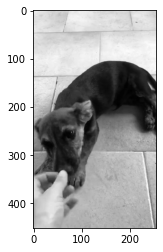

In [9]:
plt.imshow(get_plottable_frame(batch['clip'][0,:,99,:,:]),cmap='gray')

In [28]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 2466-EC75

 Directory of C:\Users\Shir\Documents\GitHub\video_autoencoder

24/11/2020  16:12    <DIR>          .
24/11/2020  16:12    <DIR>          ..
22/11/2020  23:49             1,928 .gitignore
22/11/2020  23:49    <DIR>          .idea
22/11/2020  23:53    <DIR>          .ipynb_checkpoints
23/11/2020  11:09             4,374 AuxiliaryFunctions.py
22/11/2020  23:49             2,538 Net.py
22/11/2020  23:49                79 README.md
24/11/2020  16:12            38,449 TrainingNotebook.ipynb
22/11/2020  23:49             2,859 VideoDataset.py
22/11/2020  23:49             2,280 VideoTransforms.py
24/11/2020  14:10    <DIR>          __pycache__
               7 File(s)         52,507 bytes
               5 Dir(s)  181,220,077,568 bytes free


In [22]:
vid1=cv2.VideoCapture(os.path.join(directory,'vid1.avi'))
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
vid_writer = cv2.VideoWriter(os.path.join(directory,'vid2.avi'), fourcc, 30,
                                     (int(vid1.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid1.get(cv2.CAP_PROP_FRAME_HEIGHT))), True)
for i in range(150):
    ret,frame = vid1.read()


In [24]:
while ret:
    ret,frame = vid1.read()
    vid_writer.write(frame)
vid1.release()
vid_writer.release()

In [64]:
vid1=cv2.VideoCapture(os.path.join(directory,'vid2.avi'))

In [89]:
samp=ds[0]['clip'].to(device)
samp = samp[np.newaxis,:,:,:,:]

In [90]:
with torch.no_grad():
    recon = model(samp)

In [91]:
clip=recon.cpu()

In [102]:
fourcc = cv2.VideoWriter_fourcc(*"MJPG")
vid_writer=cv2.VideoWriter(os.path.join(directory,'samp.avi'), fourcc, 30,
                                     (int(vid1.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid1.get(cv2.CAP_PROP_FRAME_HEIGHT))), False)

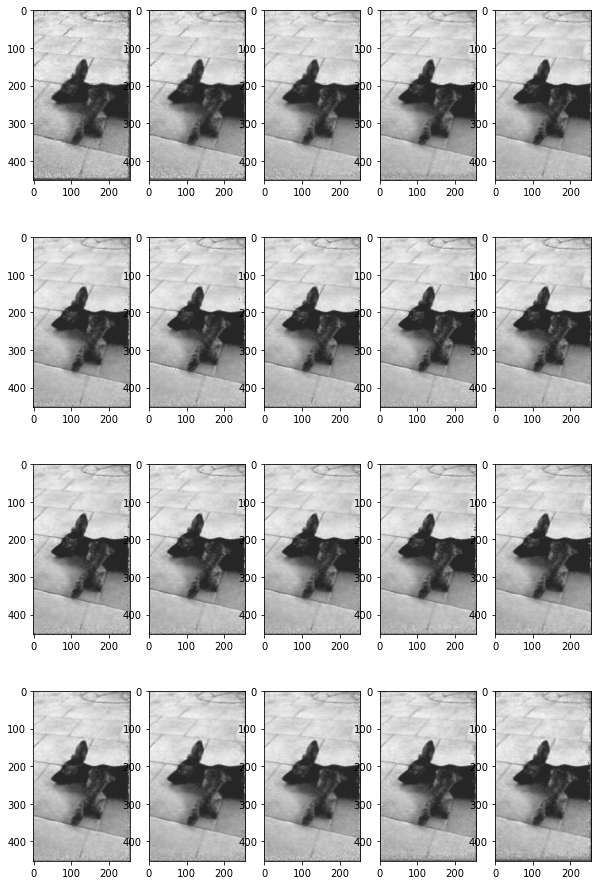

In [103]:
plt.figure(figsize=(10,16))
for i in range(1,clip.shape[2]+1):
    plt.subplot(4,5,i)
    plt.imshow((get_plottable_frame(clip[0,:,i-1,:,:])*255).astype(np.uint8),cmap='gray')
    vid_writer.write((get_plottable_frame(clip[0,:,i-1,:,:])*255).astype(np.uint8))
vid_writer.release()

In [57]:
directory=str(Path('G:/My Drive/PhD/regularvid/holdout'))#'/Volumes/GoogleDrive/My Drive/PhD/regular_vid'#
#'/Volumes/GoogleDrive/My Drive/PhD/cut_swim_samples'
ds=VideoDataset(directory,num_frames=20, 
                transform=transforms.Compose([Rescale(256),ToTensor()]),swim_sample=False)
dataloader = DataLoader(ds, batch_size=1,
                        shuffle=False, num_workers=1)

1

In [70]:
get_plottable_frame(clip[0,:,i-1,:,:]).shape

(452, 256)